In [1]:
%matplotlib inline

import io, os, sys, types, datetime, pickle, warnings, time, operator
from colorama import Fore

warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import numpy as np
from numpy.linalg import eig, inv
import numpy.ma as ma

import math

from scipy import interpolate, spatial, stats, optimize


import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp

import seaborn as sns

import skimage.io as skiIo
from skimage import exposure, img_as_float, filters, morphology, transform

from sklearn import linear_model
from sklearn import metrics

import itertools
# https://github.com/webermarcolivier/statannot

In [2]:
module_path = os.getcwd()
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
module_path

'/Users/lily/Lily/Academic/AW_Lab/code/nsp_code_manuscript/figure_generation'

In [4]:
### import custom functions
import settings as settings
import summary_helper as my_help

In [5]:
""" ============== Golbal variables and parameters =============="""
### import path setting
paths = settings.paths

### settings about target and heel mapping.
matching_info = settings.matching_info

### settings about colormaps of graphs
color_code =  matching_info.color_code
color_code[0] = 'gray'
palette = {
    'R3':color_code[3],
    'R4':color_code[4],
    'R3/R3':color_code[3],
    'R4/R4':color_code[4]
}

### settings about figure outputs
is_save = False
fig_format = 'svg'
fig_res = 300

In [6]:
""" ===== load data ===== """

' ===== load data ===== '

In [7]:
# ====== data outputs from image processing pipeline ====== #
# Dictionaries with relative lengths and angles info for targets and heels of each bundle in each sample
# structure: {(time_id, sample_id):rel_points_sample}
#     - rel_points_sample: dictionary. {bundle_no:rel_points_bundle}
#           - rel_points_bundle: dictionary.
#                  - keys = 'T0c', 'T0l', 'T0h', 'T2c', 'T2l', 'T2h', 'T3c', 'T3l', 'T3h', 'T4c', 'T4l', 'T4h', 'T5c', 'T5l', 'T5h', 'T7c', 'T7l', 'T7h', 'center', 'R3', 'R4', 'length_one_um', 'phi_range_1', 'phi_range_2'
rel_pos_ctrl = pickle.load(open(os.path.join(paths.data_prefix, "rel_pos_ctrl.pickle"), "rb"))
rel_pos_fz = pickle.load(open(os.path.join(paths.data_prefix, "rel_pos_fz.pickle"), "rb"))
rel_pos_nic = pickle.load(open(os.path.join(paths.data_prefix, "rel_pos_nic.pickle"), "rb"))

# Dictionaries with intensity matrix and parameters of representative bundles to generate sub-figures.
# structure: {(figure_id, time_id, bundle_type ('ctrl' vs. 'pert')): bundle_data_dic}
# - bundle_data_dic: dictionary. keys = 'figure_ID', 'time_ID', 'bundle_type', 'category_ID', 'parameter', 'relative_positions', 'intensity_matrix', 'analysis_params_general'
#     - 'figure_ID', 'time_ID', 'category_ID', 'bundle_type': general information about this particular bundle.
#     - 'relative_positions': dictionary. relative positions of targets and heels of this particular bundle.
#     - 'intensity_matrix': numpy array. GFP and RFP density map of this particular bundle.
#     - 'analysis_params_general': class of settings.GeneralParams. parameters used when doing image quantification
output_data_ctrl_eg = pickle.load(open(os.path.join(paths.data_prefix, "output_data_ctrl_eg.pickle"), "rb"))
output_data_fz_eg = pickle.load(open(os.path.join(paths.data_prefix, "output_data_fz_eg.pickle"), "rb"))
output_data_nic_eg = pickle.load(open(os.path.join(paths.data_prefix, "output_data_nic_eg.pickle"), "rb"))

# ====== annotation files ====== #
### csv files contains manual annotations of images.

### controls
filepath = os.path.join(paths.data_prefix, 'annots_df_ctrl.csv')
annots_df_ctrl = pd.read_csv(filepath)
annots_df_ctrl.fillna(0, inplace = True)

### Fzs
filepath = os.path.join(paths.data_prefix, 'annots_df_fz.csv')
annots_df_fz = pd.read_csv(filepath)
annots_df_fz.fillna(0, inplace = True)

### Nics
filepath = os.path.join(paths.data_prefix, 'annots_df_nic.csv')
annots_df_nic = pd.read_csv(filepath)
annots_df_nic.fillna(0, inplace = True)

# ====== summary files ====== #
### csv files contains annotated growth cone length and angle. 
sum_df_ctrl = pd.read_csv(os.path.join(paths.data_prefix, 'summary_ctrl.csv'))
sum_df_ctrl = sum_df_ctrl.loc[~sum_df_ctrl['CategoryID'].isna(),:]

sum_df_fz = pd.read_csv(os.path.join(paths.data_prefix, 'summary_fz.csv'))
sum_df_fz = sum_df_fz.loc[~sum_df_fz['CategoryID'].isna(),:]

sum_df_nic = pd.read_csv(os.path.join(paths.data_prefix, 'summary_nic.csv'))
sum_df_nic = sum_df_nic.loc[~sum_df_nic['CategoryID'].isna(),:]

In [8]:
"""===== procesing ====="""

'===== procesing ====='

In [9]:
# ====== process summary files ====== #
### Combines image annotation information and growth cone angle and length annotation information.
### controls
print("=== Control ===")
sum_df_ctrl[['TimeID', 'SampleID', 'bundle_no']] = sum_df_ctrl[['TimeID', 'SampleID', 'bundle_no']].astype('int64')
sum_df_ctrl_final = my_help.process_sum_df(sum_df_ctrl, annots_df_ctrl, rel_pos_ctrl, True)
sum_df_ctrl_final.sort_values(by =['TimeID', 'SampleID', 'bundle_no'], inplace = True)

### Fzs
print("\n=== Fz ===")
sum_df_fz[['TimeID', 'SampleID', 'bundle_no']] = sum_df_fz[['TimeID', 'SampleID', 'bundle_no']].astype('int64')
sum_df_fz_final = my_help.process_sum_df(sum_df_fz, annots_df_fz, rel_pos_fz, False)
sum_df_fz_final.sort_values(by =['TimeID', 'SampleID', 'bundle_no'], inplace = True)

### Nics
print("\n=== Nic ===")
sum_df_nic[['TimeID', 'SampleID', 'bundle_no']] = sum_df_nic[['TimeID', 'SampleID', 'bundle_no']].astype('int64')
sum_df_nic_final = my_help.process_sum_df(sum_df_nic, annots_df_nic, rel_pos_nic, False)
sum_df_nic_final.sort_values(by =['TimeID', 'SampleID', 'bundle_no'], inplace = True)

# ====== regression analysis on repulsion model ===== #
my_help.mutual_repulsion_regression(sum_df_ctrl_final, annots_df_ctrl)

=== Control ===
Calculate Mutual Repulsion!
22_hrs_sample_2, 22_hrs_sample_3, 22_hrs_sample_11, 24_hrs_sample_21, 24_hrs_sample_22, 24_hrs_sample_23, 26_hrs_sample_21, 26_hrs_sample_23, 26_hrs_sample_24, 28_hrs_sample_5, 28_hrs_sample_21, 28_hrs_sample_22, 30_hrs_sample_21, 30_hrs_sample_22, 32_hrs_sample_12, 32_hrs_sample_13, 36_hrs_sample_21, 36_hrs_sample_22, 36_hrs_sample_23, 
=== Fz ===
Calculate Mutual Repulsion!
22_hrs_sample_1, 22_hrs_sample_3, 22_hrs_sample_4, 22_hrs_sample_5, 28_hrs_sample_1, 28_hrs_sample_2, 28_hrs_sample_9, 28_hrs_sample_23, 28_hrs_sample_24, 28_hrs_sample_26, 28_hrs_sample_38, 
=== Nic ===
Calculate Mutual Repulsion!
22_hrs_sample_2, 22_hrs_sample_4, 22_hrs_sample_5, 28_hrs_sample_2, 28_hrs_sample_8, 28_hrs_sample_9, 28_hrs_sample_12, 28_hrs_sample_23, 28_hrs_sample_29, === Regression result ===
r_type = R3: alpha = 1.04, beta = 0.44, R^2 = 0.75
r_type = R4: alpha = 1.00, beta = 0.64, R^2 = 0.88
=== Regression direction calculation ===
22_hrs_sample_2; 22_

In [10]:
""" ===== plotting ===== """

' ===== plotting ===== '

In [11]:
"""Figure 2"""

'Figure 2'

(121, 77)


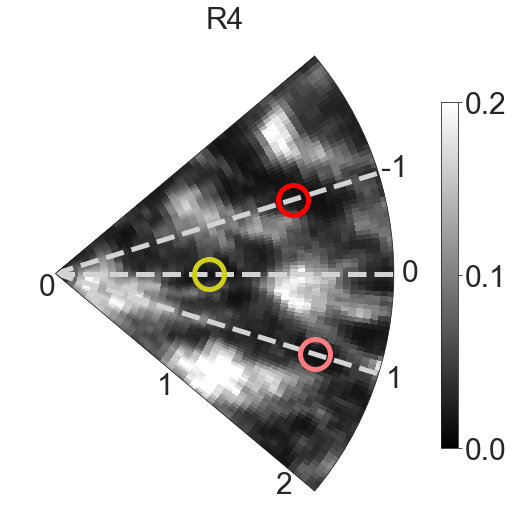

In [12]:
### representative GFP density map in Figure 2.
my_help.generate_density_plot_figure(output_data_ctrl_eg[('Fig2', 22, 'ctrl')], 
                                     is_save = is_save, channels = ['GFP'], gfp_cmap = [0.2, [0, 0.1, 0.2]],
                                     fig_name = 'Figure2', fig_format = fig_format, fig_res = fig_res)

In [13]:
"""Figure 3A"""

'Figure 3A'

(121, 77)


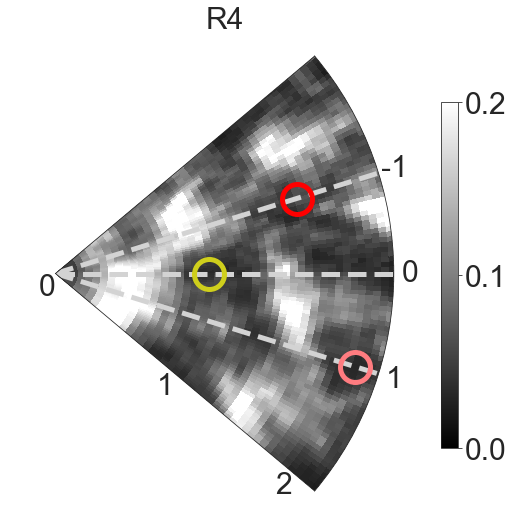

(121, 77)


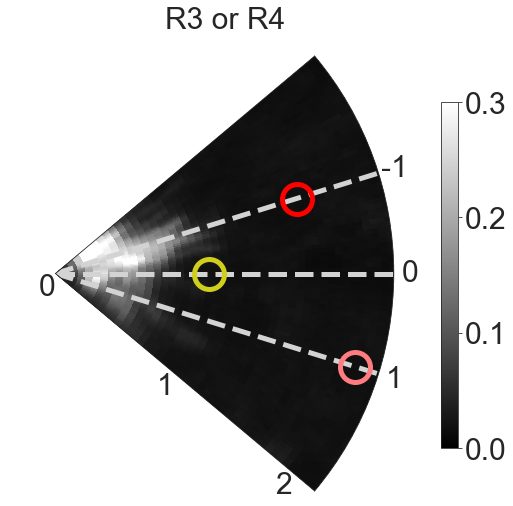

In [14]:
## Representative GFP and RFP density map of wild-type bundles at 22 hrs
my_help.generate_density_plot_figure(output_data_ctrl_eg[('Fig3', 22, 'ctrl')], 
                                     is_save = is_save, channels = ['GFP', 'RFP'], 
                                     gfp_cmap = [0.2, [0, 0.1, 0.2]], rfp_cmap = [0.3, [0, 0.1, 0.2, 0.3]],
                                     fig_name = 'Figure3A_22hrs', fig_format = fig_format, fig_res = fig_res)

(121, 77)


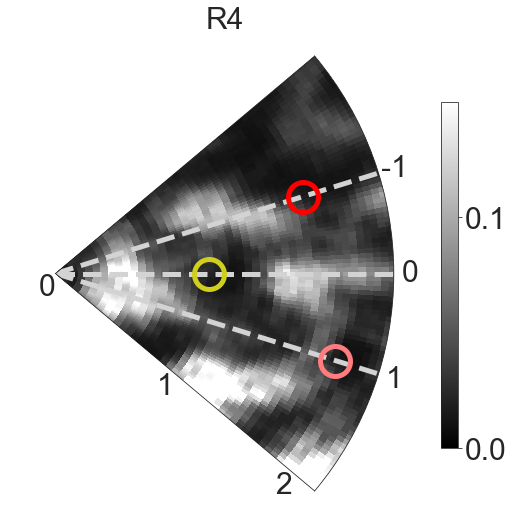

(121, 77)


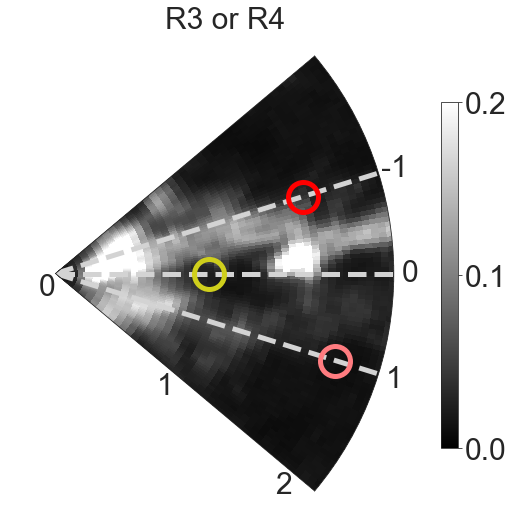

In [15]:
## Representative GFP and RFP density map of wild-type bundles at 28 hrs
my_help.generate_density_plot_figure(output_data_ctrl_eg[('Fig3', 28, 'ctrl')], 
                                     is_save = is_save, channels = ['GFP', 'RFP'], 
                                     gfp_cmap = [0.15, [0, 0.1]], rfp_cmap = [0.2, [0, 0.1, 0.2]],
                                     fig_name = 'Figure3A_28hrs', fig_format = fig_format, fig_res = fig_res)

(121, 77)


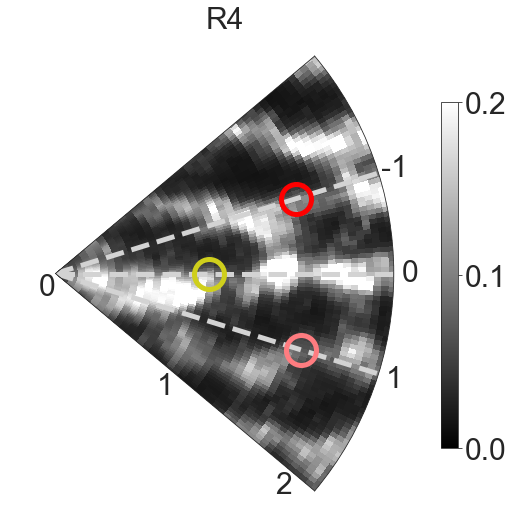

(121, 77)


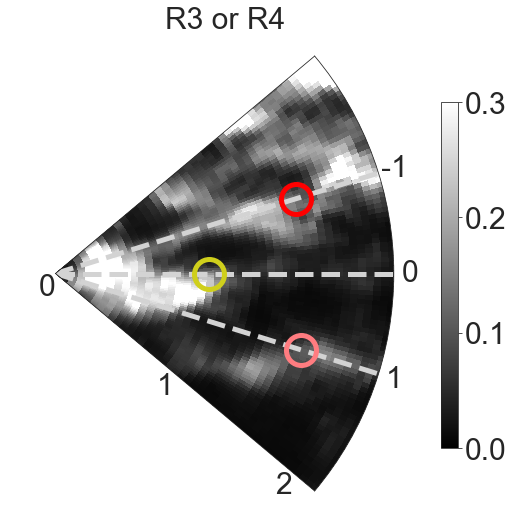

In [16]:
## Representative GFP and RFP density map of wild-type bundles at 32 hrs
my_help.generate_density_plot_figure(output_data_ctrl_eg[('Fig3', 32, 'ctrl')], 
                                     is_save = is_save, channels = ['GFP', 'RFP'], 
                                     gfp_cmap = [0.2, [0, 0.1, 0.2]], rfp_cmap = [0.3, [0, 0.1, 0.2, 0.3]],
                                     fig_name = 'Figure3A_32hrs', fig_format = fig_format, fig_res = fig_res)

In [17]:
"""Figure S2"""

'Figure S2'

(121, 77)


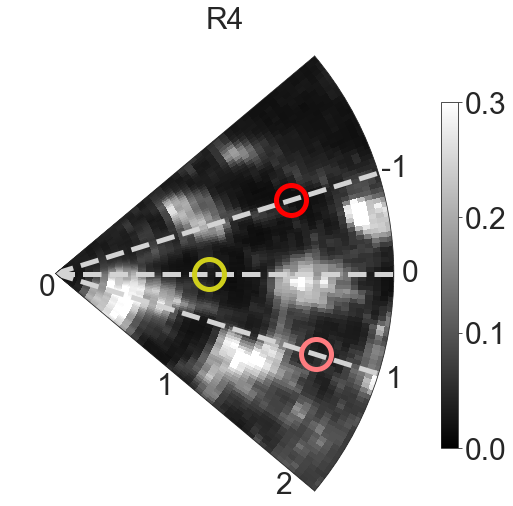

(121, 77)


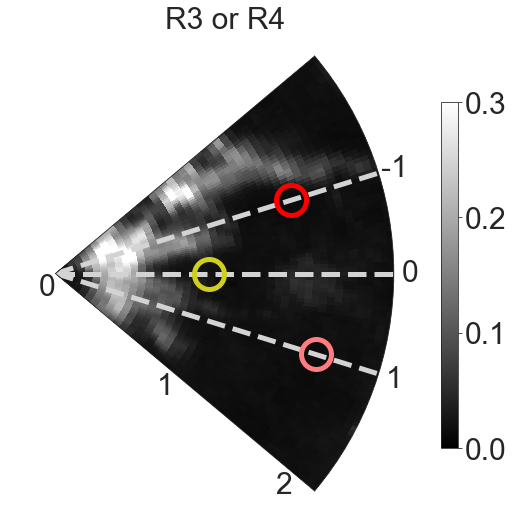

In [18]:
## Representative GFP and RFP density map of wild-type bundles at 24 hrs
my_help.generate_density_plot_figure(output_data_ctrl_eg[('FigS2', 24, 'ctrl')], 
                                     is_save = is_save, channels = ['GFP', 'RFP'], 
                                     gfp_cmap = [0.3, [0, 0.1, 0.2, 0.3]], rfp_cmap = [0.3, [0, 0.1, 0.2, 0.3]],
                                     fig_name = 'FigureS2_24hrs', fig_format = fig_format, fig_res = fig_res)

(121, 77)


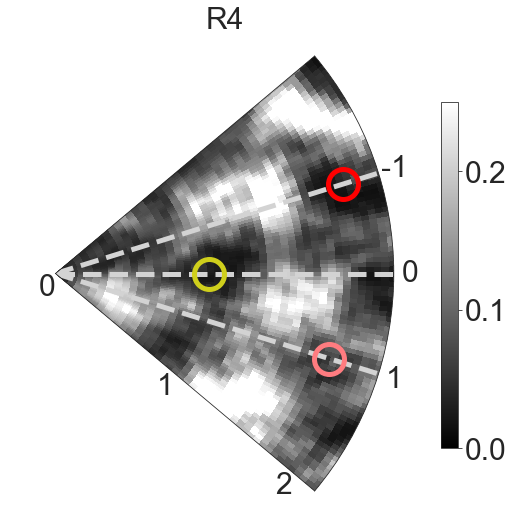

(121, 77)


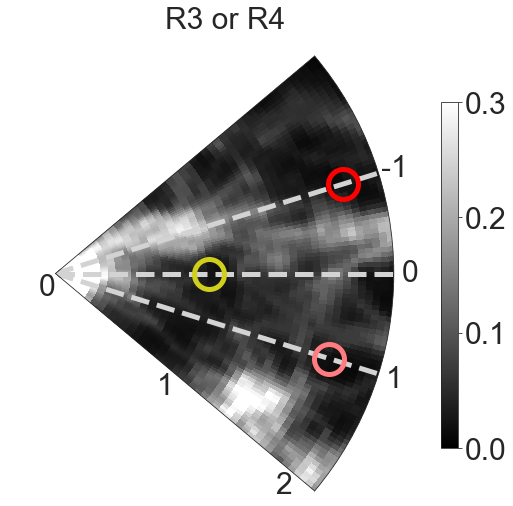

In [19]:
## Representative GFP and RFP density map of wild-type bundles at 26 hrs
my_help.generate_density_plot_figure(output_data_ctrl_eg[('FigS2', 26, 'ctrl')], 
                                     is_save = is_save, channels = ['GFP', 'RFP'], 
                                     gfp_cmap = [0.25, [0, 0.1, 0.2]], rfp_cmap = [0.3, [0, 0.1, 0.2, 0.3]],
                                     fig_name = 'FigureS2_26hrs', fig_format = fig_format, fig_res = fig_res)

(121, 77)


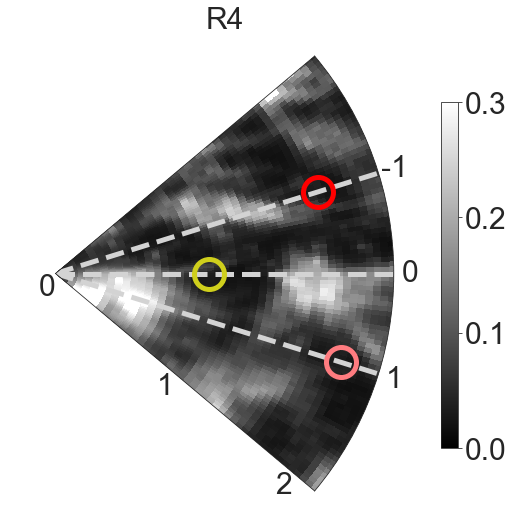

(121, 77)


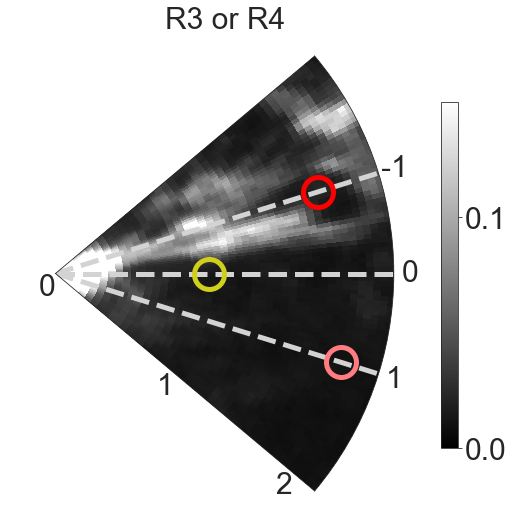

In [20]:
## Representative GFP and RFP density map of wild-type bundles at 30 hrs
my_help.generate_density_plot_figure(output_data_ctrl_eg[('FigS2', 30, 'ctrl')], 
                                     is_save = is_save, channels = ['GFP', 'RFP'], 
                                     gfp_cmap = [0.3, [0, 0.1, 0.2, 0.3]], rfp_cmap = [0.15, [0, 0.1]],
                                     fig_name = 'FigureS2_30hrs', fig_format = fig_format, fig_res = fig_res)

(121, 77)


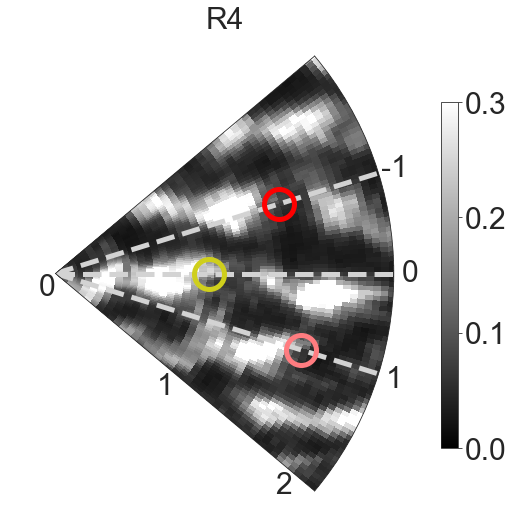

(121, 77)


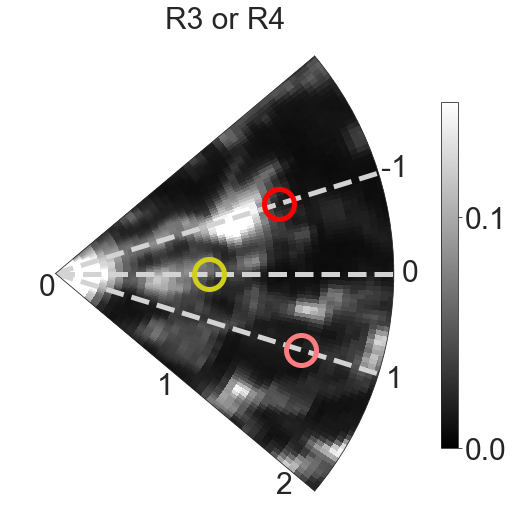

In [21]:
## Representative GFP and RFP density map of wild-type bundles at 36 hrs
my_help.generate_density_plot_figure(output_data_ctrl_eg[('FigS2', 36, 'ctrl')], 
                                     is_save = is_save, channels = ['GFP', 'RFP'], 
                                     gfp_cmap = [0.3, [0, 0.1, 0.2, 0.3]], rfp_cmap = [0.15, [0, 0.1]],
                                     fig_name = 'FigureS2_36hrs', fig_format = fig_format, fig_res = fig_res)

In [22]:
"""Figure 3B"""
### Relative length of R3 and R4s from wild-type flies over time.

'Figure 3B'

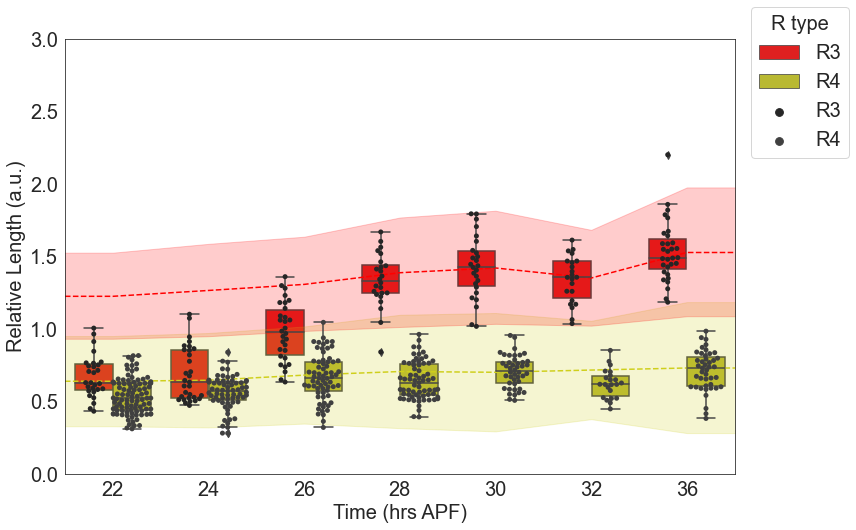

In [23]:
# ====== Figure ====== #
### set parameters
df_current = sum_df_ctrl_final
x_cat = 'TimeID'
y_cat = 'length_gc'
hue = 'type_plot'
df_plot = df_current[[x_cat, y_cat, hue]].dropna(how='any')
ylim = [0, 3]
ylabel = 'Relative Length (a.u.)'
xlabel = 'Time (hrs APF)'

### calculate T3/T4 range
times = len(df_current.groupby(x_cat).groups)
x = np.arange(times+2)-1
y = np.zeros((6, times+2))

y[0,1:-1] = df_current.groupby(x_cat).mean()['T4l_fromheel']
y[1,1:-1] = df_current.groupby(x_cat).mean()['T4h_fromheel']
y[2,1:-1] = df_current.groupby(x_cat).mean()['T4c_fromheel']
y[3,1:-1] = df_current.groupby(x_cat).mean()['T3l_fromheel']
y[4,1:-1] = df_current.groupby(x_cat).mean()['T3h_fromheel']
y[5,1:-1] = df_current.groupby(x_cat).mean()['T3c_fromheel']
y[:,0] = y[:,1]
y[:,-1] = y[:,-2]

### figure set-up
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 28
plt.rc('font', size=SMALL_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)   # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

sns.set_style("white")

### plotting
fig, ax = plt.subplots(1,1, figsize = (12,8))
if('length' in y_cat):
    ax.plot(x, y[2,:], '--', color = color_code[4], label='_nolegend_')
    ax.plot(x, y[5,:], '--', color = color_code[3], label='_nolegend_')
    ax.fill_between(x, y[1,:], y[0,:], color=color_code[4], alpha=0.2, label='_nolegend_')
    ax.fill_between(x, y[3,:], y[4,:], color=color_code[3], alpha=0.2, label='_nolegend_')

sns.boxplot(x=x_cat, y=y_cat, data=df_plot, hue = hue, dodge = True, palette = palette, ax = ax)
sns.swarmplot(x=x_cat, y=y_cat, data=df_plot, color = '.25', hue = hue, dodge = True, ax = ax)
# g.legend.remove()
ax.set_ylim(ylim)
ax.set_ylabel(ylabel)
ax.set_xlabel(xlabel)
ax.tick_params(axis = 'y', labelleft = [0,1,2,3,4])

ax.legend(title = 'R type', loc='center left', bbox_to_anchor=(1.01, 0.9))

if(is_save):
    fig_name = f'Figure3B.{fig_format}'
    fig_save_path = os.path.join(paths.output_prefix, fig_name)
    plt.savefig(fig_save_path, dpi=fig_res, bbox_inches='tight', format = fig_format)

plt.show()

In [24]:
# ====== speed of R3s and R4s ====== #
X = np.array([24, 26, 28])
print("R3 extension speed:")
r_type = "R3"
y = np.zeros((3))
for i in range(3):
    y[i] = df_plot.groupby(hue).get_group(r_type).groupby(x_cat).mean()[y_cat][X[i]]
_, _, _ = my_help.fit_linear(X, y)

print("R4 extension speed:")
r_type = "R4"
y = np.zeros((3))
for i in range(3):
    y[i] = df_plot.groupby(hue).get_group(r_type).groupby(x_cat).mean()[y_cat][X[i]]
_, _, _ = my_help.fit_linear(X, y)

R3 extension speed:
k = 0.16, R^2 = 1.00
R4 extension speed:
k = 0.02, R^2 = 0.55


In [25]:
# ====== p values of relative length ====== #

In [26]:
r_type = "R3"
df_r = df_plot.groupby(hue).get_group(r_type)

data = [df_r.loc[ids, y_cat].values for ids in df_r.groupby(x_cat).groups.values()]
H, p = ss.kruskal(*data)
sp.posthoc_mannwhitney(df_r, val_col=y_cat, group_col=x_cat, p_adjust = 'holm')

,22,24,26,28,30,32,36
22,1.000000e+00,1.000000e+00,3.234886e-06,1.748745e-08,5.298413e-09,2.414723e-08,9.391394e-10
24,1.000000e+00,1.000000e+00,1.844593e-05,1.515318e-08,3.092119e-09,1.748745e-08,2.943877e-10
26,3.234886e-06,1.844593e-05,1.000000e+00,4.666322e-06,2.421812e-07,4.895690e-06,1.690415e-09
28,1.748745e-08,1.515318e-08,4.666322e-06,1.000000e+00,5.919573e-01,1.000000e+00,6.475853e-03
30,5.298413e-09,3.092119e-09,2.421812e-07,5.919573e-01,1.000000e+00,5.919573e-01,3.968286e-01
32,2.414723e-08,1.748745e-08,4.895690e-06,1.000000e+00,5.919573e-01,1.000000e+00,6.475853e-03
36,9.391394e-10,2.943877e-10,1.690415e-09,6.475853e-03,3.968286e-01,6.475853e-03,1.000000e+00


In [27]:
r_type = "R4"
df_r = df_plot.groupby(hue).get_group(r_type)

data = [df_r.loc[ids, y_cat].values for ids in df_r.groupby(x_cat).groups.values()]
H, p = ss.kruskal(*data)
sp.posthoc_mannwhitney(df_r, val_col=y_cat, group_col=x_cat, p_adjust = 'holm')

,22,24,26,28,30,32,36
22,1.000000e+00,5.501189e-01,0.000003,0.000026,7.616711e-10,0.027060,1.309132e-08
24,5.501189e-01,1.000000e+00,0.000985,0.024617,2.620573e-07,0.362244,7.041743e-07
26,2.784565e-06,9.846501e-04,1.000000,0.991426,7.270853e-01,0.991426,6.350218e-01
28,2.609409e-05,2.461738e-02,0.991426,1.000000,6.490352e-02,1.000000,3.562252e-02
30,7.616711e-10,2.620573e-07,0.727085,0.064904,1.000000e+00,0.059484,1.000000e+00
32,2.705960e-02,3.622435e-01,0.991426,1.000000,5.948419e-02,1.000000,7.439599e-02
36,1.309132e-08,7.041743e-07,0.635022,0.035623,1.000000e+00,0.074396,1.000000e+00


In [28]:
"""Figure 3C"""
### Relative angle of R3 and R4s from wild-type flies over time.

'Figure 3C'

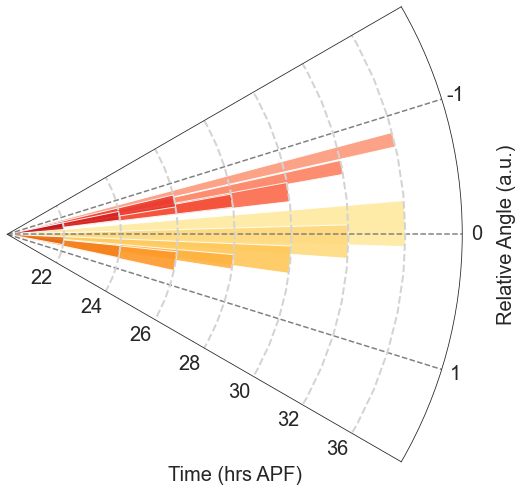

In [29]:
# ====== Figure ====== #
### set parameters
x_cat = 'TimeID'
y_cat = 'angle_gc'
hue = "type_plot"
xlim = 8

colors1 = plt.cm.Reds(np.linspace(0, 1, 15))
colors1 = colors1[5:,:]

colors2 = plt.cm.YlOrBr(np.linspace(0, 1, 15))
colors2 = colors2[3:,:]

phi_unit = my_help.get_angle_unit_theory('phi_unit')

### calculate values
r3_control = sum_df_ctrl_final.groupby(hue).get_group('R3')
r4_control = sum_df_ctrl_final.groupby(hue).get_group('R4')

theta1 = r3_control.groupby(x_cat).mean()[y_cat].to_numpy()
width1 = r3_control.groupby(x_cat).std()[y_cat].to_numpy()

theta2 = r4_control.groupby(x_cat).mean()[y_cat].to_numpy()
width2 = r4_control.groupby(x_cat).std()[y_cat].to_numpy()

radii1 = np.arange(len(theta1))+1
radii2 = np.arange(len(theta2))+1

theta1 = np.flip(theta1)
radii1 = np.flip(radii1)
width1 = np.flip(width1)
theta2 = np.flip(theta2)
radii2 = np.flip(radii2)
width2 = np.flip(width2)

dTiCs = {}
target_grid_polar = my_help.get_target_grid_polar_summary(return_type = 'theory', dTiCs = dTiCs)

### figure set-up
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 28
plt.rc('font', size=SMALL_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)   # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title



### plotting
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.79], polar=True)

# plot reference line
ax.plot([0,0], [0,xlim], '--', color = 'Gray', linewidth = 1.5)
ax.plot([0,target_grid_polar[2,0]], [0,xlim], '--', color = 'Gray', linewidth = 1.5)
ax.plot([0,target_grid_polar[5,0]], [0,xlim], '--', color = 'Gray', linewidth = 1.5)

for i in range(len(radii1)):
    r = np.arange(-1, 1, 0.1)
    theta = np.zeros((r.shape)) + radii1[i]
    ax.plot(r,theta,'--', color = 'LightGray', linewidth = 2)

ax.bar(theta1, radii1, width=width1, bottom=0.0, color = colors1, alpha = 0.9)
ax.bar(theta2, radii2, width=width2, bottom=0.0, color = colors2, alpha=0.9)

ax.set_thetamin(-30)
ax.set_thetamax(30)
ax.set_rlim(0, xlim)

plt.yticks(ticks = [1, 2, 3, 4, 5, 6, 7], labels = ["22", "24", "26", "28", "30", "32", "36"])
plt.xticks(ticks = [-phi_unit, 0, phi_unit], labels = [1, 0, -1])
ax.set_xlabel("Time (hrs APF)")
ax.yaxis.set_label_position("right")
plt.ylabel("Relative Angle (a.u.)", labelpad=35)

ax.grid(False)

if(is_save):
    fig_name = f'Figure3C.{fig_format}'
    fig_save_path = os.path.join(paths.output_prefix, fig_name)
    plt.savefig(fig_save_path, dpi=fig_res, bbox_inches='tight', format = fig_format, facecolor='w')
plt.show()

In [30]:
# ====== p values ====== #
x_cat = 'TimeID'
y_cat = 'angle_gc_mrr'
hue = 'type_plot'
df_plot = sum_df_ctrl_final[[x_cat, y_cat, hue]].dropna(how='any')
df_group = df_plot.groupby(x_cat)
for gp in df_group.groups.keys():
    print(f'{gp} hrs')
    my_help.p_value_3c(df_group.get_group(gp), hue, y_cat, [['R3', 'R4']], False, 'Mann-Whitney')

22 hrs
count: R3 = 28, num R4 = 96
KS normality test: pa = 1.8643054421365873e-05, pb = 3.9255461811743783e-16
Mann-Whitney test: 0.2728058026874264
24 hrs
count: R3 = 31, num R4 = 67
KS normality test: pa = 1.5354040786257524e-07, pb = 2.5773390327963616e-13
Mann-Whitney test: 0.4965625466311312
26 hrs
count: R3 = 30, num R4 = 67
KS normality test: pa = 1.2345767433753006e-08, pb = 2.3874073305521927e-13
Mann-Whitney test: 0.06267063791096383
28 hrs
count: R3 = 24, num R4 = 67
KS normality test: pa = 3.445916115919399e-06, pb = 2.156886128617954e-15
Mann-Whitney test: 0.05797883446436505
30 hrs
count: R3 = 26, num R4 = 44
KS normality test: pa = 6.749740209654259e-07, pb = 7.746874970720223e-09
Mann-Whitney test: 0.0018992176498910432
32 hrs
count: R3 = 22, num R4 = 22
KS normality test: pa = 8.448333784306197e-07, pb = 0.0004045155736724926
Mann-Whitney test: 9.293505048467219e-08
36 hrs
count: R3 = 31, num R4 = 43
KS normality test: pa = 1.3877303924073748e-09, pb = 2.63202481457303

In [31]:
"""Figure 4"""
### Relative length and angle of R3 and R4s from sev>Fz and sev>Nic flies at 22 or 28 hrs APF.

'Figure 4'

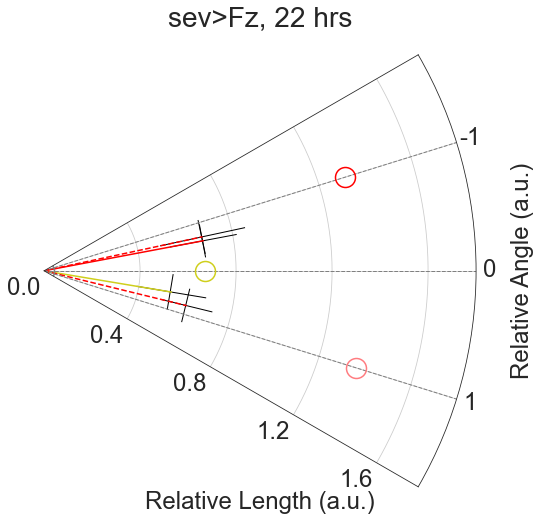

In [32]:
pert_cat = 'Fz'
time_id = 22

if(pert_cat == 'Nic'):
    pert_type = 'R4/R4'
    pert_rtype = 4
    plot_df = sum_df_nic_final.groupby('TimeID').get_group(time_id)
elif(pert_cat == 'Fz'):
    pert_type = 'R3/R3'
    pert_rtype = 3
    plot_df = sum_df_fz_final.groupby('TimeID').get_group(time_id)

pert_info = time_id, pert_cat, pert_type, pert_rtype
my_help.generate_summary_polar_figure(plot_df, pert_info,  
                                      is_save = is_save, fig_format = fig_format, fig_res = fig_res)

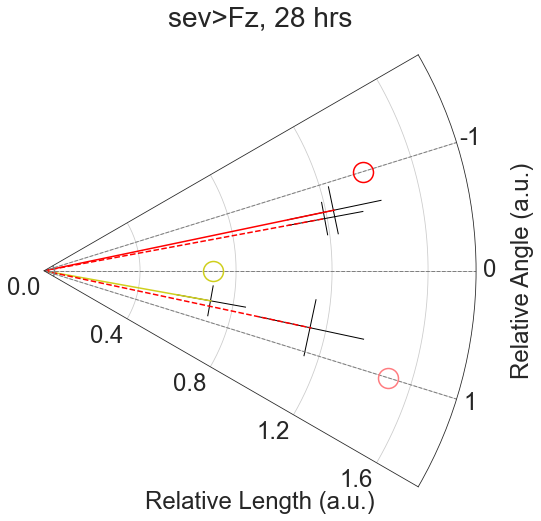

In [33]:
pert_cat = 'Fz'
time_id = 28

if(pert_cat == 'Nic'):
    pert_type = 'R4/R4'
    pert_rtype = 4
    plot_df = sum_df_nic_final.groupby('TimeID').get_group(time_id)
elif(pert_cat == 'Fz'):
    pert_type = 'R3/R3'
    pert_rtype = 3
    plot_df = sum_df_fz_final.groupby('TimeID').get_group(time_id)

pert_info = time_id, pert_cat, pert_type, pert_rtype
my_help.generate_summary_polar_figure(plot_df, pert_info, 
                                      is_save = is_save, fig_format = fig_format, fig_res = fig_res)

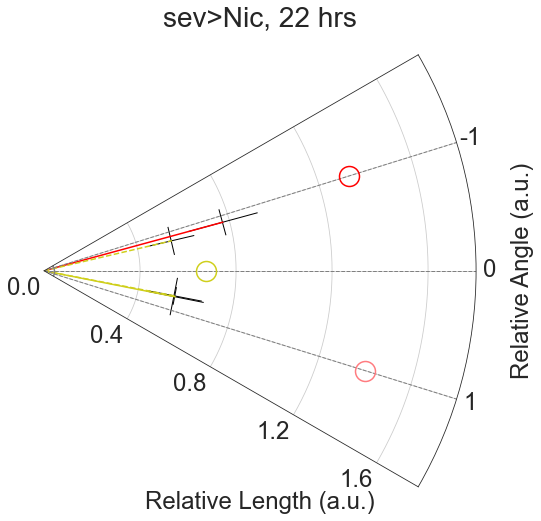

In [34]:
pert_cat = 'Nic'
time_id = 22

if(pert_cat == 'Nic'):
    pert_type = 'R4/R4'
    pert_rtype = 4
    plot_df = sum_df_nic_final.groupby('TimeID').get_group(time_id)
elif(pert_cat == 'Fz'):
    pert_type = 'R3/R3'
    pert_rtype = 3
    plot_df = sum_df_fz_final.groupby('TimeID').get_group(time_id)

pert_info = time_id, pert_cat, pert_type, pert_rtype
my_help.generate_summary_polar_figure(plot_df, pert_info, 
                                     is_save = is_save, fig_format = fig_format, fig_res = fig_res)

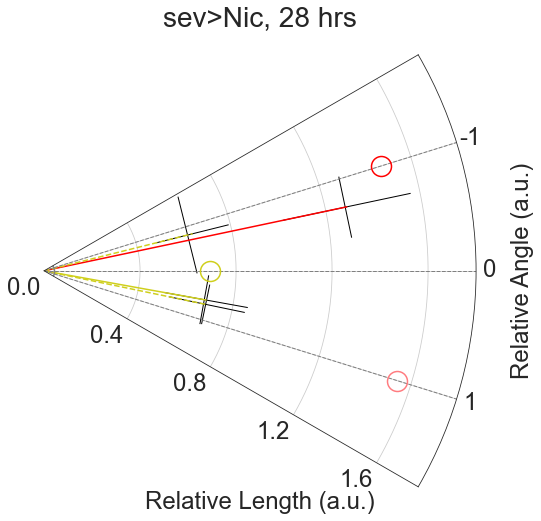

In [35]:
pert_cat = 'Nic'
time_id = 28

if(pert_cat == 'Nic'):
    pert_type = 'R4/R4'
    pert_rtype = 4
    plot_df = sum_df_nic_final.groupby('TimeID').get_group(time_id)
elif(pert_cat == 'Fz'):
    pert_type = 'R3/R3'
    pert_rtype = 3
    plot_df = sum_df_fz_final.groupby('TimeID').get_group(time_id)

pert_info = time_id, pert_cat, pert_type, pert_rtype
my_help.generate_summary_polar_figure(plot_df, pert_info, 
                                      is_save = is_save, fig_format = fig_format, fig_res = fig_res)

In [36]:
# ====== p values: Fz, 22 hrs ====== #
pert_cat = 'Fz'
time_id = 22
x_cat = "type_plot"

if(pert_cat == 'Nic'):
    plot_df = sum_df_nic_final.groupby('TimeID').get_group(time_id)
    criteria = (plot_df['type_bundle'] == 'R4R4') | (plot_df['type_bundle'] == 'R3R4')
    df_current = plot_df[criteria]
elif(pert_cat == 'Fz'):
    plot_df = sum_df_fz_final.groupby('TimeID').get_group(time_id)
    criteria = (plot_df['type_bundle'] == 'R3R3') | (plot_df['type_bundle'] == 'R3R4')
    df_current = plot_df[criteria]
    

y_cat = 'length_gc'
my_help.p_value_4(df_current, x_cat, y_cat, pert_cat, time_id)

y_cat = 'angle_gc_mrr'
my_help.p_value_4(df_current, x_cat, y_cat, pert_cat, time_id)

===Fz_22hrs_length===
R3 vs R4: 0.004209574504763764
R3/R3(3) vs R3/R3(4): 1.0
R3 vs R3/R3(3): 1.0
R3 vs R3/R3(4): 1.0
===Fz_22hrs_angle===
R3 vs R4: 1.0
R3/R3(3) vs R3/R3(4): 1.0
R3 vs R3/R3(3): 1.0
R4 vs R3/R3(4): 0.35151758318348125


In [37]:
# ====== p values: Fz, 28 hrs ====== #
pert_cat = 'Fz'
time_id = 28
x_cat = "type_plot"

if(pert_cat == 'Nic'):
    plot_df = sum_df_nic_final.groupby('TimeID').get_group(time_id)
    criteria = (plot_df['type_bundle'] == 'R4R4') | (plot_df['type_bundle'] == 'R3R4')
    df_current = plot_df[criteria]
elif(pert_cat == 'Fz'):
    plot_df = sum_df_fz_final.groupby('TimeID').get_group(time_id)
    criteria = (plot_df['type_bundle'] == 'R3R3') | (plot_df['type_bundle'] == 'R3R4')
    df_current = plot_df[criteria]
    

y_cat = 'length_gc'
my_help.p_value_4(df_current, x_cat, y_cat, pert_cat, time_id)

y_cat = 'angle_gc_mrr'
my_help.p_value_4(df_current, x_cat, y_cat, pert_cat, time_id)

===Fz_28hrs_length===
R3 vs R4: 5.026003022782858e-25
R3/R3(3) vs R3/R3(4): 1.0
R3 vs R3/R3(3): 1.0
R3 vs R3/R3(4): 0.8205862824637866
===Fz_28hrs_angle===
R3 vs R4: 0.14878752137808343
R3/R3(3) vs R3/R3(4): 1.0
R3 vs R3/R3(3): 1.0
R4 vs R3/R3(4): 0.6874601205526747


In [38]:
# ====== p values: Nic, 22 hrs ====== #
pert_cat = 'Nic'
time_id = 22
x_cat = "type_plot"

if(pert_cat == 'Nic'):
    plot_df = sum_df_nic_final.groupby('TimeID').get_group(time_id)
    criteria = (plot_df['type_bundle'] == 'R4R4') | (plot_df['type_bundle'] == 'R3R4')
    df_current = plot_df[criteria]
elif(pert_cat == 'Fz'):
    plot_df = sum_df_fz_final.groupby('TimeID').get_group(time_id)
    criteria = (plot_df['type_bundle'] == 'R3R3') | (plot_df['type_bundle'] == 'R3R4')
    df_current = plot_df[criteria]
    

y_cat = 'length_gc'
my_help.p_value_4(df_current, x_cat, y_cat, pert_cat, time_id)

y_cat = 'angle_gc_mrr'
my_help.p_value_4(df_current, x_cat, y_cat, pert_cat, time_id)

===Nic_22hrs_length===
R3 vs R4: 8.163012468686805e-06
R4/R4(4) vs R4/R4(4): 1.0
R4 vs R4/R4(3): 1.0
R4 vs R4/R4(4): 1.0
===Nic_22hrs_angle===
R3 vs R4: 0.06906839988566371
R4/R4(3) vs R4/R4(4): 1.0
R3 vs R4/R4(3): 1.0
R4 vs R4/R4(4): 1.0


In [39]:
# ====== p values: Nic, 28 hrs ====== #
pert_cat = 'Nic'
time_id = 28
x_cat = "type_plot"

if(pert_cat == 'Nic'):
    plot_df = sum_df_nic_final.groupby('TimeID').get_group(time_id)
    criteria = (plot_df['type_bundle'] == 'R4R4') | (plot_df['type_bundle'] == 'R3R4')
    df_current = plot_df[criteria]
elif(pert_cat == 'Fz'):
    plot_df = sum_df_fz_final.groupby('TimeID').get_group(time_id)
    criteria = (plot_df['type_bundle'] == 'R3R3') | (plot_df['type_bundle'] == 'R3R4')
    df_current = plot_df[criteria]
    

y_cat = 'length_gc'
my_help.p_value_4(df_current, x_cat, y_cat, pert_cat, time_id)

y_cat = 'angle_gc_mrr'
my_help.p_value_4(df_current, x_cat, y_cat, pert_cat, time_id)

===Nic_28hrs_length===
R3 vs R4: 5.8432044146201806e-18
R4/R4(4) vs R4/R4(4): 1.0
R4 vs R4/R4(3): 1.0
R4 vs R4/R4(4): 1.0
===Nic_28hrs_angle===
R3 vs R4: 0.825319508725469
R4/R4(3) vs R4/R4(4): 1.0
R3 vs R4/R4(3): 1.0
R4 vs R4/R4(4): 1.0


In [40]:
"""Figure S3"""
### Representative bundles of sev>Fz and sev>Nic flies at 22 or 28 hrs APF.

'Figure S3'

(121, 77)


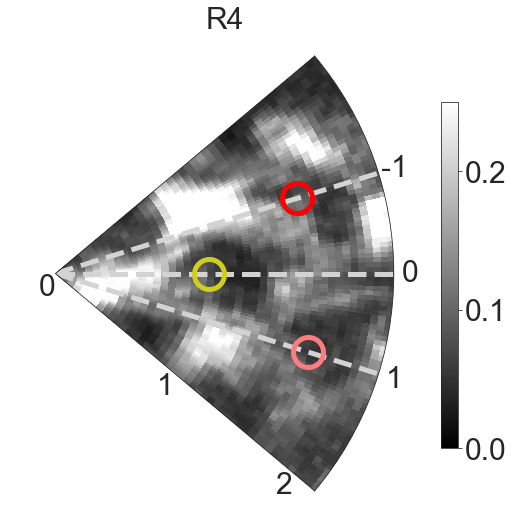

(121, 77)


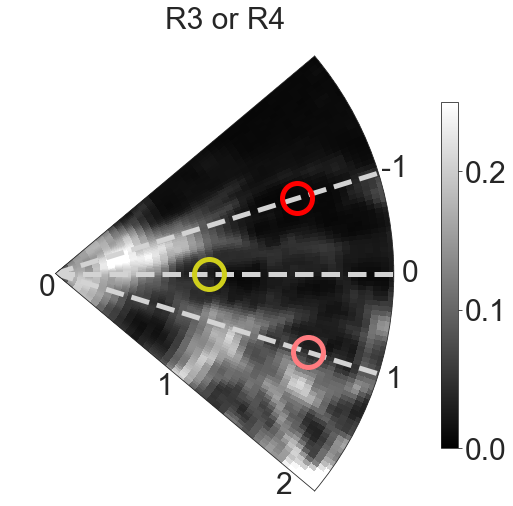

In [41]:
## sv>Fz 22 hrs, ctrl.
my_help.generate_density_plot_figure(output_data_fz_eg[('FigS3', 22, 'ctrl')], 
                                     is_save = is_save, channels = ['GFP', 'RFP'], 
                                     gfp_cmap = [0.25, [0, 0.1, 0.2]], rfp_cmap = [0.25, [0, 0.1, 0.2]],
                                     fig_name = 'FigureS3_Fz_22hrs_ctrl', fig_format = fig_format, fig_res = fig_res)

(121, 77)


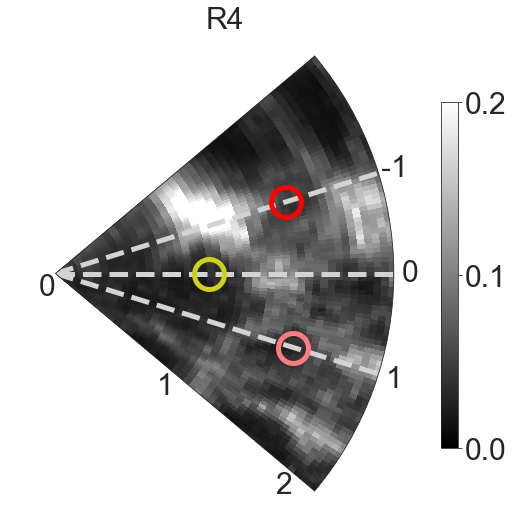

(121, 77)


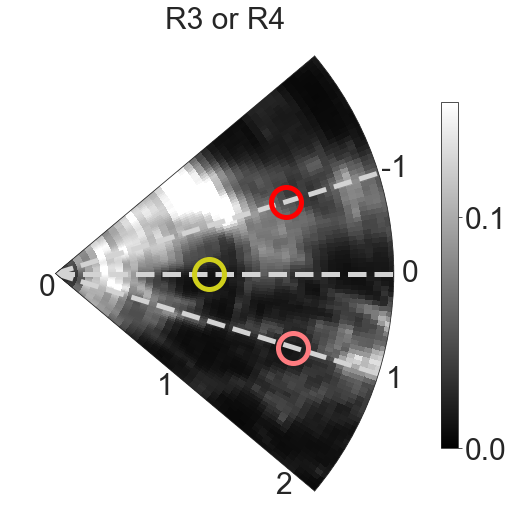

In [42]:
## sev>Fz 22 hrs, pert.
my_help.generate_density_plot_figure(output_data_fz_eg[('FigS3', 22, 'pert')], 
                                     is_save = is_save, channels = ['GFP', 'RFP'], 
                                     gfp_cmap = [0.2, [0, 0.1, 0.2]], rfp_cmap = [0.15, [0, 0.1]],
                                     fig_name = 'FigureS3_Fz_22hrs_pert', fig_format = fig_format, fig_res = fig_res)

(121, 77)


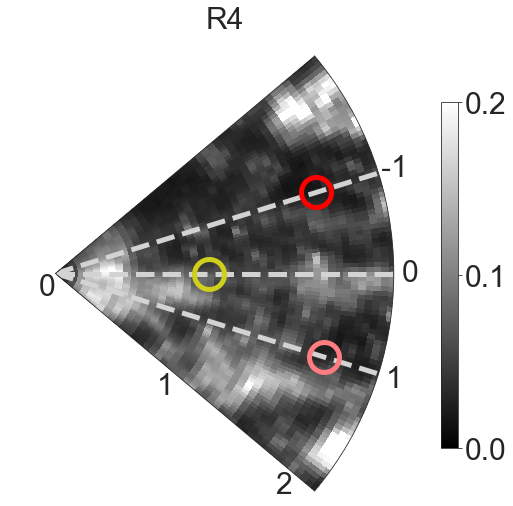

(121, 77)


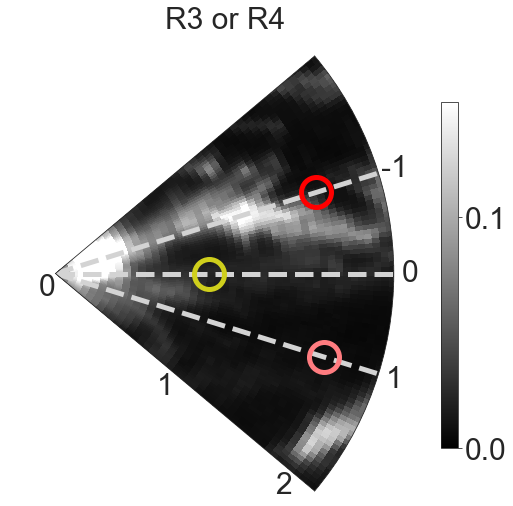

In [43]:
## sev>Fz 28 hrs, ctrl.
my_help.generate_density_plot_figure(output_data_fz_eg[('FigS3', 28, 'ctrl')], 
                                     is_save = is_save, channels = ['GFP', 'RFP'], 
                                     gfp_cmap = [0.2, [0, 0.1, 0.2]], rfp_cmap = [0.15, [0, 0.1]],
                                     fig_name = 'FigureS3_Fz_28hrs_ctrl', fig_format = fig_format, fig_res = fig_res)

(121, 77)


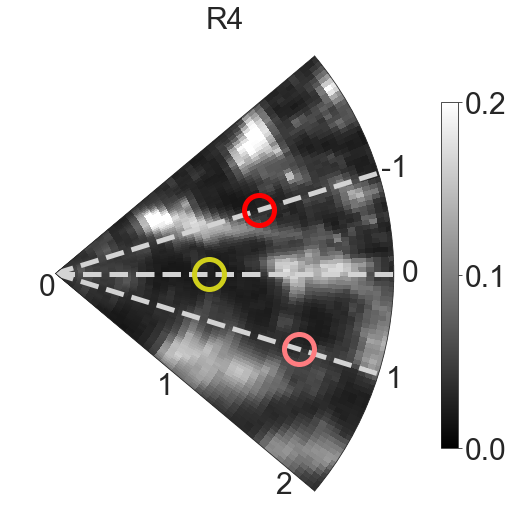

(121, 77)


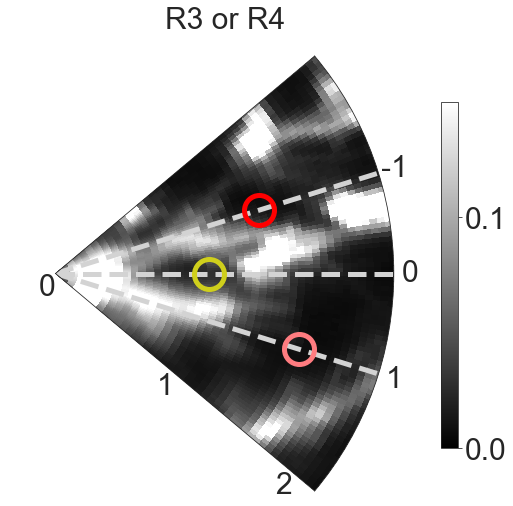

In [44]:
## sev>Fz 28 hrs, pert.
my_help.generate_density_plot_figure(output_data_fz_eg[('FigS3', 28, 'pert')], 
                                     is_save = is_save, channels = ['GFP', 'RFP'], 
                                     gfp_cmap = [0.2, [0, 0.1, 0.2]], rfp_cmap = [0.15, [0, 0.1]],
                                     fig_name = 'FigureS3_Fz_28hrs_pert', fig_format = fig_format, fig_res = fig_res)

(121, 77)


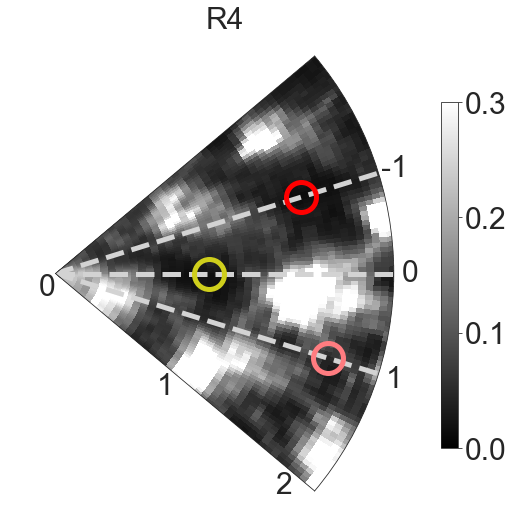

(121, 77)


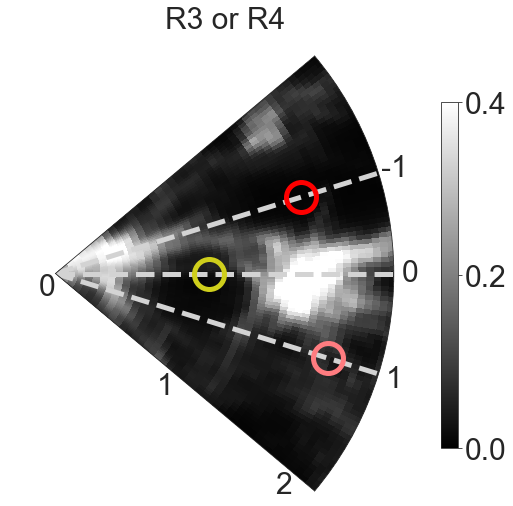

In [45]:
## sev>Nic 22 hrs, ctrl.
my_help.generate_density_plot_figure(output_data_nic_eg[('FigS3', 22, 'ctrl')], 
                                     is_save = is_save, channels = ['GFP', 'RFP'], 
                                     gfp_cmap = [0.3, [0, 0.1, 0.2, 0.3]], rfp_cmap = [0.4, [0, 0.2, 0.4]],
                                     fig_name = 'FigureS3_Nic_22hrs_ctrl', fig_format = fig_format, fig_res = fig_res)

(121, 77)


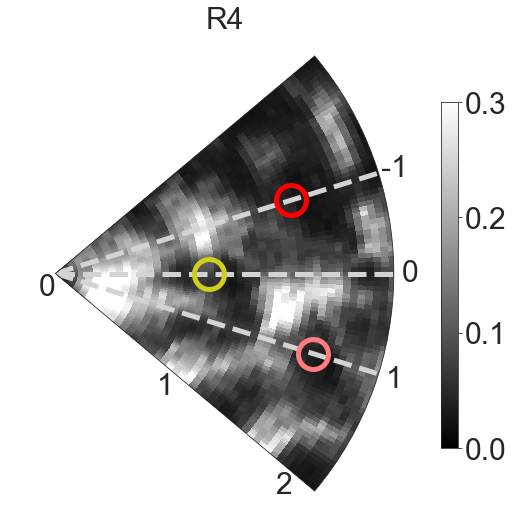

(121, 77)


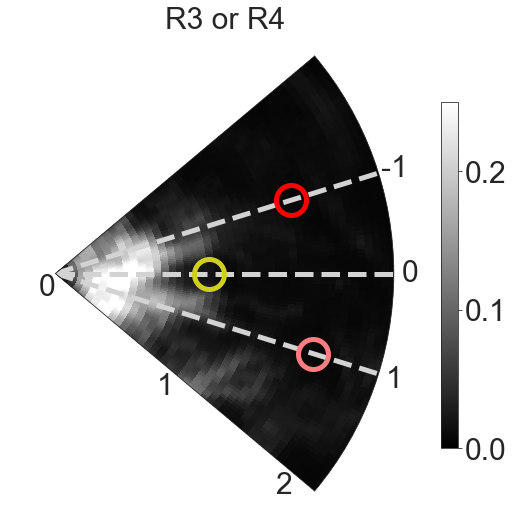

In [46]:
## sev>Nic 22 hrs, pert.
my_help.generate_density_plot_figure(output_data_nic_eg[('FigS3', 22, 'pert')], 
                                     is_save = is_save, channels = ['GFP', 'RFP'], 
                                     gfp_cmap = [0.3, [0, 0.1, 0.2, 0.3]], rfp_cmap = [0.25, [0, 0.1, 0.2]],
                                     fig_name = 'FigureS3_Nic_22hrs_pert', fig_format = fig_format, fig_res = fig_res)

(121, 77)


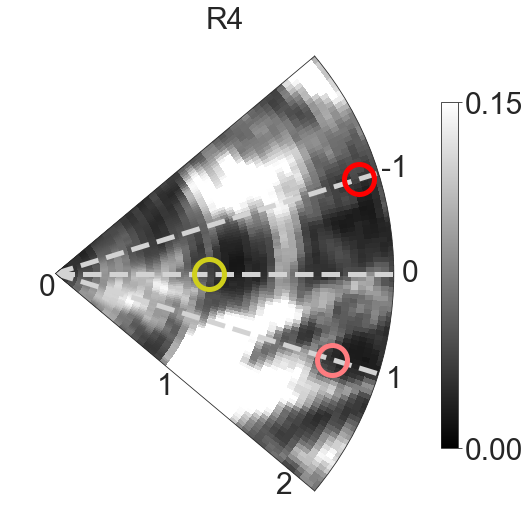

(121, 77)


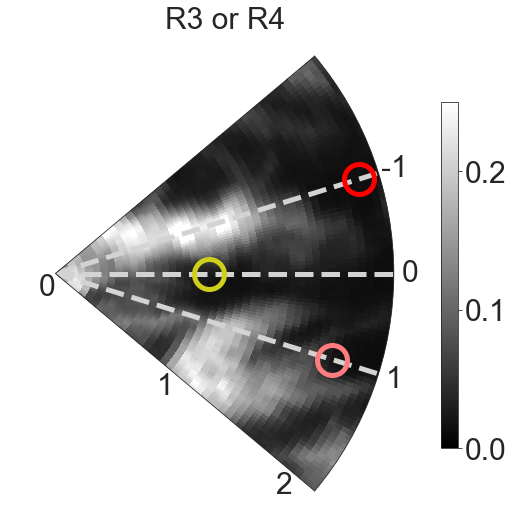

In [47]:
## sev>Nic 28 hrs, ctrl.
my_help.generate_density_plot_figure(output_data_nic_eg[('FigS3', 28, 'ctrl')], 
                                     is_save = is_save, channels = ['GFP', 'RFP'], 
                                     gfp_cmap = [0.15, [0, 0.15]], rfp_cmap = [0.25, [0, 0.1, 0.2]],
                                     fig_name = 'FigureS3_Nic_28hrs_ctrl', fig_format = fig_format, fig_res = fig_res)

(121, 77)


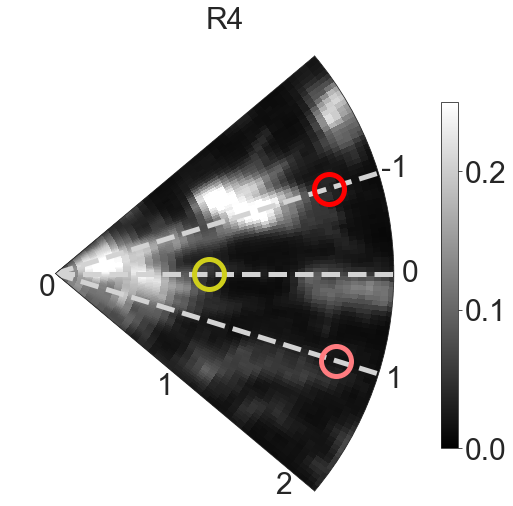

(121, 77)


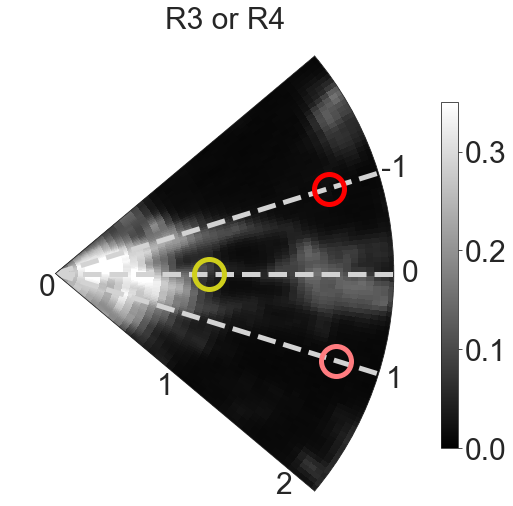

In [48]:
## sev>Nic 28 hrs, pert.
my_help.generate_density_plot_figure(output_data_nic_eg[('FigS3', 28, 'pert')], 
                                     is_save = is_save, channels = ['GFP', 'RFP'], 
                                     gfp_cmap = [0.25, [0, 0.1, 0.2]], rfp_cmap = [0.35, [0, 0.1, 0.2, 0.3]],
                                     fig_name = 'FigureS3_Nic_28hrs_pert', fig_format = fig_format, fig_res = fig_res)

In [49]:
"======= Figure S4 ======="
### Repulsion model

'======= Figure S4 ======='

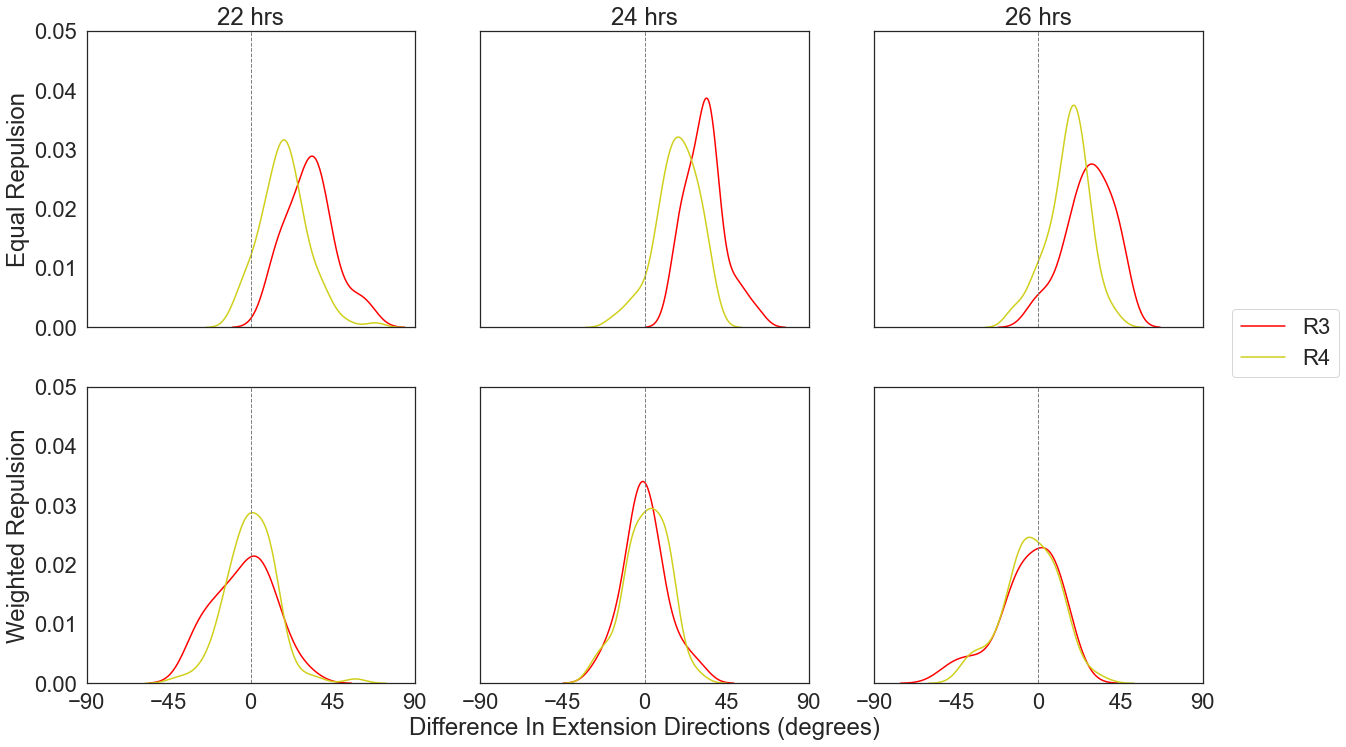

In [50]:
my_help.mutual_repulsion_regression_plot(sum_df_ctrl_final, 
                                         is_save = is_save, fig_name = 'FigureS4', 
                                         fig_format = fig_format, fig_res = fig_res)